In [25]:
from IPython.display import clear_output
import time
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import PorterStemmer
import math
import os
import matplotlib.pyplot as plt


In [2]:
import pickle
posting=pickle.load(open("backup/posting.p","rb"))
docId=pickle.load(open("backup/docId.p","rb"))
time_to_index=pickle.load(open("backup/time_to_index.p","rb"))

In [3]:
#optimized (input takes only content)
def createTokenOptimized(content):
    tokens = list()
    tokenizer = WhitespaceTokenizer()
    for token in tokenizer.tokenize(content):
        tokens.append(token)
    return tokens

#optimized (input takes only content)
def linguisticTokenOptimized(token_list):
    stemmer = PorterStemmer() #stem
    #lemmer = WordNetLemmatizer()
    tokens = list()
    regex = "[!@#$%^&*()-_=+'`~ \":;|/.,?[]{}<>]"
    for t in token_list:
        token = t.translate(str.maketrans('', '', regex)) #remove punctuations
        if token == '': #if the token is only punctuation
            continue
        token = token.lower()
        token = stemmer.stem(token)
        #token = lemmer.lemmatize(token)
        tokens.append(token)
    return tokens

#implementation of the algorithm from lecutre (for AND operations)
def mergePostings(postingList):
    result = []
    posting1 = postingList[0][1]

    for i in range(1,len(postingList),1):
        merged = []
        posting2 = postingList[i][1]
        p = 0
        q = 0
        while p < len(posting1) and q < len(posting2):
            if int(posting1[p]) == int(posting2[q]):
                merged.append(posting1[p])
                p += 1
                q += 1
            elif int(posting1[p]) < int(posting2[q]):
                p += 1
            else:
                q += 1
        posting1 = merged
    return posting1

In [4]:
def no_of_skip(arr_list):
    return math.ceil(math.sqrt(len(arr_list)))

def skp(postingList):
    posting1 = postingList[0][1]
    
    for i in range(1,len(postingList),1):
        posting2 = postingList[i][1]
        p = 0
        q = 0
        #print(posting1)
        pskip = no_of_skip(posting1)
        qskip = no_of_skip(posting2)
        p1_len = len(posting1)
        p2_len = len(posting2)
        merged = []
        
        while p < p1_len and q < p2_len:
            if int(posting1[p]) == int(posting2[q]):
                merged.append(posting1[p])
                p += 1
                q += 1

            elif int(posting1[p]) < int(posting2[q]):
                if (p1_len > (pskip+p)) and (posting1[p+pskip] <= posting2[q]):
                    p += pskip
                else:
                    p += 1

            else:
                if (p2_len > (qskip+q)) and posting2[q+qskip] <= posting1[p]:
                    q += qskip
                else:
                    q += 1
        posting1 = merged
    return posting1

def processQuery(query):
    q_token = createTokenOptimized(query)
    q_token = linguisticTokenOptimized(q_token)
    posting_list = []
    
    for token in q_token:
        try:
            posting_list.append(posting[token])
        except:
            print(token)
            posting_list.append([])
            break
    result = mergePostings(posting_list)
    return result

def processQueryShortToLong(query):
    q_token = createTokenOptimized(query)
    q_token = linguisticTokenOptimized(q_token)
    posting_list = []
    
    for token in q_token:
        try:
            posting_list.append(posting[token])
        except:
            print(token)
            posting_list.append([])
            break
    posting_list = sorted(posting_list, key=lambda x: x[0])
    result = mergePostings(posting_list)
    return result

def processQuerySkip(query):
    q_token = createTokenOptimized(query)
    q_token = linguisticTokenOptimized(q_token)
    posting_list = []
    
    for token in q_token:
        try:
            posting_list.append(posting[token])
        except:
            #print(token)
            posting_list.append([])
            break
    result = skp(posting_list)
    return result

def processQuerySkipSort(query):
    q_token = createTokenOptimized(query)
    q_token = linguisticTokenOptimized(q_token)
    posting_list = []
    
    for token in q_token:
        try:
            posting_list.append(posting[token])
        except:
            #print(token)
            posting_list.append([])
            break
    posting_list = sorted(posting_list, key=lambda x: x[0])
    result = skp(posting_list)
    return result

In [5]:
while True:
    query = input("Enter a query (type q to exit) : ")
    if query == "q":
        break
        
    clear_output()
    x=10
    
    start_time_non = time.time()
    for j in range(x):
        result = processQuery(query)
    print("Time taken to search with non sorted order: ", round((time.time()-start_time_non)/x,5))
    
#     start_time = time.time()
#     for j in range(x):
#         result = processQueryShortToLong(query)
#     print("Time taken to search with short-to-long optimization: ", round((time.time()-start_time)/x,5))
    
#     start_time_skip = time.time()
#     for j in range(x):
#         result = processQuerySkip(query)
#     print("Time taken to search with skip-pointers optimization: ", round((time.time()-start_time_skip)/x,5))
    
#     start_time_skp = time.time()
#     for j in range(x):
#         result = processQuerySkipSort(query)
#     print("Time taken to search with skip-pointers and short-to-long sorting", round((time.time()-start_time_skp)/x,5))
    
    print('')
    
    print( len(result), "documents found for '"+query+"'")
    
    print('')
    for doc in result:
        print(os.path.basename(docId[int(doc)]))

Time taken to search with non sorted order:  0.04249

3 documents found for 'test war mouse travel person fight man award'

Frozen_(2013_film).txt
Steve_Jobs#Return_to_Apple.txt
Steve_Jobs.txt
Enter a query (type q to exit) : q


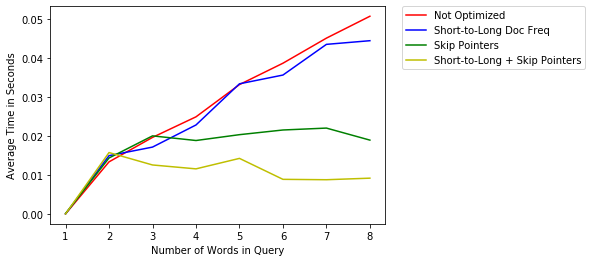

In [106]:
# to get the data points for comparing optimization methods

query = ['test','test war','test war mouse','test war mouse travel','test war mouse travel person', 
         'test war mouse travel person fight','test war mouse travel person fight man', 
         'test war mouse travel person fight man award']

x=10

notOptimized=[]
stl=[]
skipQry=[]
skipQryStl=[]

for i in query:
#     print('Query is:',i)
    start_time_non = time.time()
    for j in range(x):
        result = processQuery(i)
    notOptimized.append(round((time.time()-start_time_non)/x,5))

    start_time = time.time()
    for j in range(x):
        result = processQueryShortToLong(i)
    stl.append(round((time.time()-start_time)/x,5))

    start_time_skip = time.time()
    for j in range(x):
        result = processQuerySkip(i)
    skipQry.append(round((time.time()-start_time_skip)/x,5))

    start_time_skp = time.time()
    for j in range(x):
        result = processQuerySkipSort(i)
    skipQryStl.append(round((time.time()-start_time_skp)/x,5))

xAxis=[1,2,3,4,5,6,7,8]

plt.plot(xAxis,notOptimized,'r-',label='Not Optimized')
plt.plot(xAxis,stl,'b-',label='Short-to-Long Doc Freq')
plt.plot(xAxis,skipQry,'g-',label='Skip Pointers')
plt.plot(xAxis,skipQryStl,'y-',label='Short-to-Long + Skip Pointers')
plt.ylabel('Average Time in Seconds')
plt.xlabel('Number of Words in Query')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()